In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

import yaml

import pseudopeople as pp
from pseudopeople.utilities import get_configuration
from vivarium.framework.randomness import RandomnessStream

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Thu 06 Apr 2023 04:35:13 PM PDT
ndbs
Linux gen-slurm-sexec-p0001 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/pseudopeople_testing


# Find data

```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48/final_results/2023_04_04_16_31_24
```

In [2]:
project_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
model_dir = (
    f'{project_dir}/results'
    '/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48'
)
output_dir = f'{model_dir}/final_results/2023_04_04_16_31_24'

!ls -halt $output_dir

total 364K
drwxrwsr-x  3 rmudambi IHME-Simulationscience 1.0K Apr  4 17:46 ..
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:46 tax_dependents_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:44 tax_1040_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:37 tax_w2_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 social_security_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 wic_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 household_survey_observer_cps
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 household_survey_observer_acs
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 decennial_census_observer
drwxrwsr-x 11 rmudambi IHME-Simulationscience 4.5K Apr  4 17:02 .
drwxrwsr-x  2 rmudambi IHME-Simulationscience 334K Apr  4 16:33 logs


In [3]:
!ls -halt $output_dir/tax_w2_observer

total 321G
-rw-r--r--  1 rmudambi IHME-Simulationscience 981M Apr  4 17:37 tax_w2_observer_1299.hdf
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:37 .
-rw-r--r--  1 rmudambi IHME-Simulationscience 980M Apr  4 17:33 tax_w2_observer_9577.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 983M Apr  4 17:13 tax_w2_observer_9066.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 984M Apr  4 17:10 tax_w2_observer_352.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 981M Apr  4 17:10 tax_w2_observer_3545.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 985M Apr  4 17:10 tax_w2_observer_3481.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 982M Apr  4 17:10 tax_w2_observer_3528.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 984M Apr  4 17:10 tax_w2_observer_3240.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 981M Apr  4 17:10 tax_w2_observer_3541.hdf
-rw-r--r--  1 rmudambi IHME-Simulationscience 984M Apr  4 17:09 tax_w2_observer_1177.hdf
-rw-r--r--  1 rmudambi IHME-Simula

# Choose a random seed and define filepaths

In [9]:
seed = 9577
w2_dir = f'{output_dir}/tax_w2_observer'
census_dir = f'{output_dir}/decennial_census_observer'

w2_path = f'{w2_dir}/tax_w2_observer_{seed}.hdf'
census_path = f'{census_dir}/decennial_census_observer_{seed}.hdf'

In [10]:
w2_path

'/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48/final_results/2023_04_04_16_31_24/tax_w2_observer/tax_w2_observer_9577.hdf'

In [11]:
census_path

'/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48/final_results/2023_04_04_16_31_24/decennial_census_observer/decennial_census_observer_9577.hdf'

# Generate noisy W2/1099 data

In [12]:
%%time
df_w2_noisy = pp.generate_taxes_w2_and_1099(w2_path)
df_w2_noisy

CPU times: user 9min 48s, sys: 46.3 s, total: 10min 34s
Wall time: 10min 34s


,employer_zipcode,employer_name,age,employer_state,mailing_address_street_number,date_of_birth,mailing_address_zipcode,middle_initial,first_name,tax_form,...,mailing_address_city,ssn,mailing_address_unit_number,employer_city,employer_id,employer_street_name,income,employer_street_number,mailing_address_street_name,mailing_address_state
0,64501,Stephen DPM,36,MO,716,1984-09-23 00:00:00,<NA>,J,Stephen,W2,...,kansas city,491-66-1679,,raytown,990572,edgecliff ct,31706.337039,,highbourne ln,MO
1,19952,VUE at Musical Starts With Baby e Vino,29,DE,716,1991-12-06 00:00:00,63028,J,Sharise,W2,...,kansas city,740-75-3353,,newark,530646,n 52nd st,22320.910197,309,highbourne ln,MO
2,39159,Clean Colorado PC,60,MS,3110,1960-10-06 00:00:00,53546,J,Susan,W2,...,manitowoc,405-41-0440,aprt number 102,gulfport,213031,skyview ter,15198.896884,1960,royal gorge ct,WI
3,97124,Mendoza Foundation,57,OR,3110,1963-11-04 00:00:00,53546,J,Thomas,W2,...,manitowoc,490-11-3309,aprt number 102,sherwood,208894,ince dr,22010.993207,e,royal gorge ct,WI
4,35810,Alafair Antique Mall Greenmarket,57,AL,3110,1963-11-04 00:00:00,53546,J,Thomas,W2,...,manitowoc,490-11-3309,aprt number 102,sloss,928645,stoney crk cir,17642.758252,,royal gorge ct,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745437,60706,Connie CNP,37,IL,3607,1992-11-15 00:00:00,45036,R,Jasmine,W2,...,<NA>,025-30-1826,,oswego,1667267,mcdaniel rd,3664.499637,795,cnyn blvd.,OH
9745438,63044,Tylaska Marine Outfitters,38,MO,3607,1991-10-08 00:00:00,45036,D,Thomas,W2,...,<NA>,252-61-1750,,springfield,1064982,29 mi,1329.04403,1460,cnyn blvd.,OH
9745439,30076,Ketchikan Public Storage,19,GA,3607,2010-10-15 00:00:00,45036,D,Sofia,W2,...,liberty twp,079-96-2270,,woodstock,967110,oleander dr,990.05955,625,cnyn blvd.,OH
9745440,92675,Koudsi Nabil,24,CA,230280,2005-12-30 00:00:00,94303,L,Ryan,W2,...,<NA>,083-83-3812,,compton,722816,meadowvale dve,1409.156077,109,siesta cove dr,CA


In [13]:
%%time
print(sizemb(df_w2_noisy)) # 14.7 GB for one shard of noised W2 data

14684.479671
CPU times: user 33 s, sys: 848 ms, total: 33.8 s
Wall time: 33.8 s


# Load un-noised W2/1099 data for comparison

In [15]:
%%time
df_w2 = pd.read_hdf(w2_path)
df_w2

CPU times: user 4min 10s, sys: 22.4 s, total: 4min 32s
Wall time: 4min 33s


,employer_zipcode,employer_name,age,employer_state,mailing_address_street_number,date_of_birth,mailing_address_zipcode,middle_initial,first_name,tax_form,...,mailing_address_city,ssn,mailing_address_unit_number,employer_city,employer_id,employer_street_name,income,employer_street_number,mailing_address_street_name,mailing_address_state
0,64501,Stephen DPM,36,MO,716,1984-09-23,63028,J,Stephen,W2,...,kansas city,491-66-1679,,raytown,990572,edgecliff ct,31706.337039,,highbourne ln,MO
1,19952,VUE at Musical Starts With Baby e Vino,29,DE,716,1991-12-06,63028,J,Sharise,W2,...,kansas city,740-75-3353,,newark,530646,n 52nd st,22320.910197,309,highbourne ln,MO
2,39159,Clean Colorado PC,60,MS,3110,1960-10-06,53546,J,Susan,W2,...,manitowoc,405-41-0440,aprt number 102,gulfport,213031,skyview ter,15198.896884,1960,royal gorge ct,WI
3,97124,Mendoza Foundation,57,OR,3110,1963-11-04,53546,J,Thomas,W2,...,manitowoc,490-11-3309,aprt number 102,sherwood,208894,ince dr,22010.993207,e,royal gorge ct,WI
4,35810,Alafair Antique Mall Greenmarket,57,AL,3110,1963-11-04,53546,J,Thomas,W2,...,manitowoc,490-11-3309,aprt number 102,sloss,928645,stoney crk cir,17642.758252,,royal gorge ct,WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745437,60706,Connie CNP,37,IL,3607,1992-11-15,45036,R,Jasmine,W2,...,liberty twp,025-30-1826,,oswego,1667267,mcdaniel rd,3664.499637,795,cnyn blvd.,OH
9745438,63044,Tylaska Marine Outfitters,38,MO,3607,1991-10-08,45036,D,Thomas,W2,...,liberty twp,252-61-1750,,springfield,1064982,29 mi,1329.044030,1460,cnyn blvd.,OH
9745439,30076,Ketchikan Public Storage,19,GA,3607,2010-10-15,45036,D,Sofia,W2,...,liberty twp,079-96-2270,,woodstock,967110,oleander dr,990.059550,625,cnyn blvd.,OH
9745440,92675,Koudsi Nabil,24,CA,230280,2005-12-30,94303,L,Ryan,W2,...,alpine,083-83-3812,,compton,722816,meadowvale dve,1409.156077,109,siesta cove dr,CA


In [17]:
%%time
print(sizemb(df_w2)) # 15.5 GB for one shard of un-noised W2 data

12333.659208
CPU times: user 29.4 s, sys: 1.67 s, total: 31.1 s
Wall time: 31 s


# Save the number of records in the file for convenience

n = 9,763,205

In [18]:
n = len(df_w2)
n

9745442

In [19]:
n == len(df_w2_noisy)

True

# Compare the two

In [20]:
%%time
df_w2.compare(df_w2_noisy)

CPU times: user 2min 25s, sys: 26.7 s, total: 2min 51s
Wall time: 2min 51s


employer_zipcode         employer_name        age        \
                    self   other          self other self other   
0                    NaN     NaN           NaN   NaN   36    36   
1                    NaN     NaN           NaN   NaN   29    29   
2                    NaN     NaN           NaN   NaN   60    60   
3                    NaN     NaN           NaN   NaN   57    57   
4                    NaN     NaN           NaN   NaN   57    57   
...                  ...     ...           ...   ...  ...   ...   
9745437              NaN     NaN           NaN   NaN   37    37   
9745438              NaN     NaN           NaN   NaN   38    38   
9745439              NaN     NaN           NaN   NaN   19    19   
9745440              NaN     NaN           NaN   NaN   24    24   
9745441            90011  910011           NaN   NaN   27    27   

        employer_state       mailing_address_street_number        ...  \
                  self other                          self other  ...   
0                  NaN   NaN                           NaN   NaN  ...   
1                  NaN   NaN                           NaN   NaN  ...   
2                  NaN   NaN                           NaN   NaN  ...   
3                  NaN   NaN                           NaN   NaN  ...   
4                  NaN   NaN                           NaN   NaN  ...   
...                ...   ...                           ...   ...  ...   
9745437            NaN   NaN                           NaN   NaN  ...   
9745438            NaN   NaN                           NaN   NaN  ...   
9745439            NaN   NaN                           NaN   NaN  ...   
9745440            NaN   NaN                           NaN   NaN  ...   
9745441            NaN   NaN                           NaN   NaN  ...   

        employer_street_name              income                \
                        self other          self         other   
0                        NaN   NaN  31706.337039  31706.337039   
1                        NaN   NaN  22320.910197  22320.910197   
2                        NaN   NaN  15198.896884  15198.896884   
3                        NaN   NaN  22010.993207  22010.993207   
4                        NaN   NaN  17642.758252  17642.758252   
...                      ...   ...           ...           ...   
9745437                  NaN   NaN   3664.499637   3664.499637   
9745438                  NaN   NaN   1329.044030    1329.04403   
9745439                  NaN   NaN    990.059550     990.05955   
9745440                  NaN   NaN   1409.156077   1409.156077   
9745441                  NaN   NaN   1890.851164   1890.851164   

        employer_street_number       mailing_address_street_name        \
                          self other                        self other   
0                          NaN   NaN                         NaN   NaN   
1                          NaN   NaN                         NaN   NaN   
2                          NaN   NaN                         NaN   NaN   
3                          NaN   NaN                         NaN   NaN   
4                          NaN   NaN                         NaN   NaN   
...                        ...   ...                         ...   ...   
9745437                    NaN   NaN                         NaN   NaN   
9745438                    NaN   NaN                         NaN   NaN   
9745439                    NaN   NaN                         NaN   NaN   
9745440                    NaN   NaN                         NaN   NaN   
9745441                    NaN   NaN                         NaN   NaN   

        mailing_address_state        
                         self other  
0                         NaN   NaN  
1                         NaN   NaN  
2                         NaN   NaN  
3                         NaN   NaN  
4                          WI  <NA>  
...                       ...   ...  
9745437                   NaN   NaN  
9745438               

# See what columns are in the data

In [21]:
df_w2.columns

Index(['employer_zipcode', 'employer_name', 'age', 'employer_state',
       'mailing_address_street_number', 'date_of_birth',
       'mailing_address_zipcode', 'middle_initial', 'first_name', 'tax_form',
       'tax_year', 'employer_unit_number', 'last_name',
       'mailing_address_po_box', 'simulant_id', 'mailing_address_city', 'ssn',
       'mailing_address_unit_number', 'employer_city', 'employer_id',
       'employer_street_name', 'income', 'employer_street_number',
       'mailing_address_street_name', 'mailing_address_state'],
      dtype='object')

# See which columns changed

All except `'simulant_id'`, `'tax_year'` (good, these two should not have noise), and `'mailing_address_po_box'` (but I would expect this column to have noise).

In [22]:
%%time
(df_w2 == df_w2_noisy).all()

CPU times: user 46.8 s, sys: 3.44 s, total: 50.3 s
Wall time: 50.2 s


employer_zipcode                 False
employer_name                    False
age                              False
employer_state                   False
mailing_address_street_number    False
date_of_birth                    False
mailing_address_zipcode          False
middle_initial                   False
first_name                       False
tax_form                         False
tax_year                          True
employer_unit_number             False
last_name                        False
mailing_address_po_box           False
simulant_id                       True
mailing_address_city             False
ssn                              False
mailing_address_unit_number      False
employer_city                    False
employer_id                      False
employer_street_name             False
income                           False
employer_street_number           False
mailing_address_street_name      False
mailing_address_state            False
dtype: bool

# See which un-noised columns have missing values

```
mailing_address_street_name
employer_unit_number
mailing_address_unit_number
employer_name
mailing_address_street_number
employer_street_number
```

In [23]:
%%time
(df_w2 == '').any()

CPU times: user 22.8 s, sys: 545 ms, total: 23.4 s
Wall time: 23.3 s


employer_zipcode                 False
employer_name                    False
age                              False
employer_state                   False
mailing_address_street_number     True
date_of_birth                    False
mailing_address_zipcode          False
middle_initial                   False
first_name                       False
tax_form                         False
tax_year                         False
employer_unit_number              True
last_name                        False
mailing_address_po_box           False
simulant_id                      False
mailing_address_city             False
ssn                              False
mailing_address_unit_number       True
employer_city                    False
employer_id                      False
employer_street_name             False
income                           False
employer_street_number            True
mailing_address_street_name       True
mailing_address_state            False
dtype: bool

# See which _noised_ columns have missing data

All except `'tax_year'`, `'simulant_id'`, and `'mailing_address_po_box'`. These are the same three columns that didn't change after noising, which makes sense.

In [24]:
%%time
(df_w2_noisy == '').any()

CPU times: user 26.5 s, sys: 2.93 s, total: 29.5 s
Wall time: 29.4 s


employer_zipcode                 False
employer_name                    False
age                              False
employer_state                   False
mailing_address_street_number     True
date_of_birth                    False
mailing_address_zipcode          False
middle_initial                   False
first_name                       False
tax_form                         False
tax_year                         False
employer_unit_number              True
last_name                        False
mailing_address_po_box           False
simulant_id                      False
mailing_address_city             False
ssn                              False
mailing_address_unit_number       True
employer_city                    False
employer_id                      False
employer_street_name             False
income                           False
employer_street_number            True
mailing_address_street_name       True
mailing_address_state            False
dtype: bool

# See if any missing values ended up non-missing

No. Good.

In [25]:
%%time
((df_w2 == '') & (df_w2_noisy != '')).any()

CPU times: user 50 s, sys: 5.33 s, total: 55.3 s
Wall time: 55.2 s


employer_zipcode                 False
employer_name                    False
age                              False
employer_state                   False
mailing_address_street_number    False
date_of_birth                    False
mailing_address_zipcode          False
middle_initial                   False
first_name                       False
tax_form                         False
tax_year                         False
employer_unit_number             False
last_name                        False
mailing_address_po_box           False
simulant_id                      False
mailing_address_city             False
ssn                              False
mailing_address_unit_number      False
employer_city                    False
employer_id                      False
employer_street_name             False
income                           False
employer_street_number           False
mailing_address_street_name      False
mailing_address_state            False
dtype: bool

# Look further into the mailing address PO box column

Is 0 a valid PO Box, or does that indicate "No PO box"? Looks like the latter, as that's the most common.

In [26]:
df_w2.mailing_address_po_box.nunique()

12723

In [27]:
df_w2.mailing_address_po_box.unique()

array([    0, 15162,  6719, ..., 17452,  6222, 10730])

In [28]:
df_w2.mailing_address_po_box.value_counts()

0        9427109
11899        146
416          145
2449         131
6422         130
          ...   
18093          1
4918           1
4689           1
16425          1
5030           1
Name: mailing_address_po_box, Length: 12723, dtype: int64

In [29]:
config = get_configuration()
config

decennial_census:
    omission:
        base: 0.0145
            source: initial data
    duplication:
        base: 0.05
            source: initial data
    age:
        missing_data:
            row_noise_level:
                base: 0.01
                    source: initial data
        typographic:
            row_noise_level:
                base: 0.01
                    source: initial data
            token_noise_level:
                base: 0.1
                    source: initial data
            include_original_token_level:
                base: 0.1
                    source: initial data
        age_miswriting:
            row_noise_level:
                base: 0.01
                    source: initial data
            token_noise_level:
                base: 0.1
                    source: initial data
            possible_perturbations:
                1:
                    base: 0.5
                        source: initial data
                -1:
                    bas

In [30]:
[k for k in config['taxes_w2_and_1099'].keys() if 'mailing' in k]

['mailing_address_city',
 'mailing_address_state',
 'mailing_address_street_name',
 'mailing_address_street_number',
 'mailing_address_unit_number',
 'mailing_address_po_box',
 'mailing_address_zipcode']

In [31]:
[k for k in config['taxes_w2_and_1099'].keys() if 'employer' in k]

['employer_city',
 'employer_id',
 'employer_name',
 'employer_state',
 'employer_street_name',
 'employer_street_number',
 'employer_unit_number',
 'employer_zipcode']

# Calculate fraction of rows with noise in each column

In [32]:
%%time
percent_noised = 100 * (df_w2_noisy != df_w2).sum() / n
percent_noised

CPU times: user 51.6 s, sys: 5.01 s, total: 56.6 s
Wall time: 56.5 s


employer_zipcode                 1.414661
employer_name                    1.825602
age                              2.967623
employer_state                   1.975980
mailing_address_street_number    2.134639
date_of_birth                    2.974950
mailing_address_zipcode          1.407212
middle_initial                   1.095651
first_name                       1.459554
tax_form                         1.497326
tax_year                         0.000000
employer_unit_number             0.137839
last_name                        1.482939
mailing_address_po_box           2.969634
simulant_id                      0.000000
mailing_address_city             1.578810
ssn                              2.215836
mailing_address_unit_number      0.124366
employer_city                    1.568374
employer_id                      2.967387
employer_street_name             1.655389
income                           2.967223
employer_street_number           2.195683
mailing_address_street_name      1

# Compute percent non-missing values with noise

These were the columns with missing values:
```
mailing_address_street_name
employer_unit_number
mailing_address_unit_number
employer_name
mailing_address_street_number
employer_street_number
```

In [33]:
%%time
percent_nonmissing_noised = 100 * (df_w2_noisy != df_w2).sum() / (df_w2 != '').sum()
percent_nonmissing_noised

CPU times: user 1min 11s, sys: 3.75 s, total: 1min 15s
Wall time: 1min 15s


employer_zipcode                 1.414661
employer_name                    1.825602
age                              2.967623
employer_state                   1.975980
mailing_address_street_number    2.301556
date_of_birth                    2.974950
mailing_address_zipcode          1.407212
middle_initial                   1.095651
first_name                       1.459554
tax_form                         1.497326
tax_year                         0.000000
employer_unit_number             2.497555
last_name                        1.482939
mailing_address_po_box           2.969634
simulant_id                      0.000000
mailing_address_city             1.578810
ssn                              2.215836
mailing_address_unit_number      2.483607
employer_city                    1.568374
employer_id                      2.967387
employer_street_name             1.655389
income                           2.967223
employer_street_number           2.296490
mailing_address_street_name      1

# Plot the percent of values with noise in each column

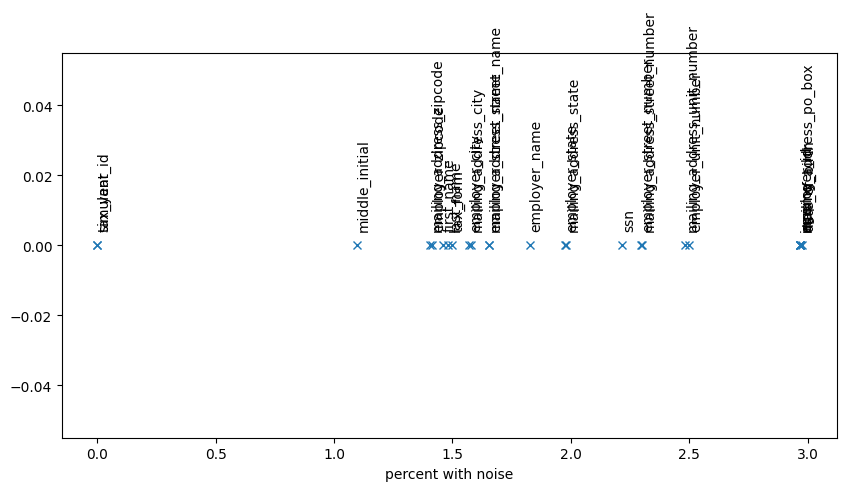

In [34]:
def scatter_1d(series, ax=None):
    if ax is None:
        ax = plt.gca()
    x = series
    y = np.zeros_like(series)
    col_name = series.index
    ax.plot(x, y, 'x')
    for col_name_i, xi, yi in zip(col_name, x, y+0.005):
        ax.annotate(col_name_i, (xi, yi), rotation=90)
    ax.set_xlabel('percent with noise')
    
fig, ax = plt.subplots(figsize=(10,5))
scatter_1d(percent_nonmissing_noised, ax)

# Zoom in on columns that actually have noise

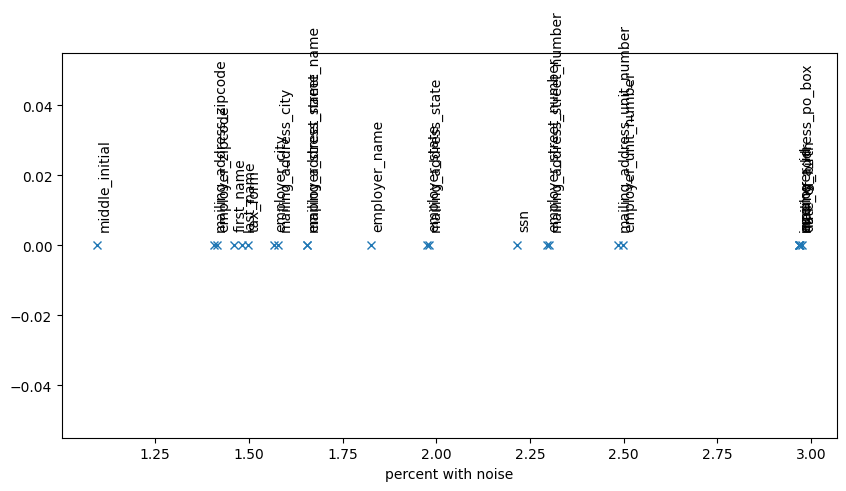

In [36]:
cols_to_omit = [
    'tax_year', 'simulant_id', # These have zero noise
#     'tax_form', # This has about 1.5% noise
#     'mailing_address_state', 'employer_state', # These have about 2% noise
]
fig, ax = plt.subplots(figsize=(10,5))
scatter_1d(percent_nonmissing_noised.drop(cols_to_omit), ax)

# Why do the "state" columns have 2% noise?

It must be about the probabilities. See how many different types of noise each column is getting.

## The only columns getting 2 noise types are the 3 columns with percentage noised values significantly larger than 1%

That's a good sign... let's see if we can compute the expected percentages below.

In [37]:
[k for k in config['taxes_w2_and_1099'].keys() if 'state' in k]

['employer_state', 'mailing_address_state']

In [38]:
config['taxes_w2_and_1099']['employer_state']

missing_data:
    row_noise_level:
        base: 0.01
            source: initial data
incorrect_selection:
    row_noise_level:
        base: 0.01
            source: initial data

In [39]:
config['taxes_w2_and_1099']['mailing_address_state']

missing_data:
    row_noise_level:
        base: 0.01
            source: initial data
incorrect_selection:
    row_noise_level:
        base: 0.01
            source: initial data

In [40]:
1-.99**2 # = 1 - (1-.01)*(1-.01)

0.01990000000000003

In [41]:
.99**2

0.9801

In [42]:
.99**3

0.970299

In [43]:
len(config['taxes_w2_and_1099']['mailing_address_state'].keys())

2

In [44]:
type(config['taxes_w2_and_1099']['mailing_address_state'])

vivarium.config_tree.ConfigTree

In [45]:
from vivarium.config_tree import ConfigTree

In [46]:
two_noise_types = [
    k for k in config['taxes_w2_and_1099'].keys()
     if isinstance(config['taxes_w2_and_1099'][k], ConfigTree)
     and len(config['taxes_w2_and_1099'][k].keys()) == 2
]
two_noise_types

['employer_city',
 'employer_name',
 'employer_state',
 'employer_street_name',
 'employer_zipcode',
 'first_name',
 'last_name',
 'mailing_address_city',
 'mailing_address_state',
 'mailing_address_street_name',
 'mailing_address_zipcode',
 'middle_initial',
 'tax_form']

In [47]:
for col in two_noise_types:
    print(col, config['taxes_w2_and_1099'][col], sep='\n\n')
    print('\n')

employer_city

missing_data:
    row_noise_level:
        base: 0.01
typographic:
    row_noise_level:
        base: 0.01
    token_noise_level:
        base: 0.1
    include_original_token_level:
        base: 0.1


employer_name

missing_data:
    row_noise_level:
        base: 0.01
typographic:
    row_noise_level:
        base: 0.01
    token_noise_level:
        base: 0.1
    include_original_token_level:
        base: 0.1


employer_state

missing_data:
    row_noise_level:
        base: 0.01
incorrect_selection:
    row_noise_level:
        base: 0.01


employer_street_name

missing_data:
    row_noise_level:
        base: 0.01
typographic:
    row_noise_level:
        base: 0.01
    token_noise_level:
        base: 0.1
    include_original_token_level:
        base: 0.1


employer_zipcode

missing_data:
    row_noise_level:
        base: 0.01
typographic:
    row_noise_level:
        base: 0.01
    token_noise_level:
        base: 0.1
    include_original_token_level:
        b

# How do we compute the correct probabilities for getting noise?

For incorrect select: P(different state | selected) = 49 / 50, so

P(different state)  = P(different state | selected) P(selected) = (49/50) * 0.01 = 0.98 * 0.01 = 0.0098.

### Thus, using the inclusion-exclusion formula:

P(different) = P(different state or missing)

= P(different state) + P(missing) - P(different state and missing)

= P(different state) + P(missing) - P(different state) * P(missing)

= 0.0098 + 0.01 - 0.0098 * 0.01

= 0.019702

In [48]:
49/50 *.01

0.0098

In [49]:
0.0098 + 0.01 - 0.0098 * 0.01

0.019701999999999997

In [50]:
.01+.01-.01*.01 # = .01(2-.01)

0.0199

In [51]:
1-0.0199

0.9801

# Here's a different way to compute the same thing:

For "incorrect selection" noise:

P(same state | selected) = 1/50, so

P(same state) = P(same state | selected) P(selected) + P(same state | not selected) P(not selected)

= (1/50) * (1/100) + 1 * (99/100)

= 0.0002 + 0.99

= 0.9902

### Now think of 2 independent steps for changing or not changing the value:

1. Decide missing -- P(not missing) = 1 - 0.01 = 0.99
2. Pick random state -- P(same state) = 0.9902

So

P(no noise) = P(not missing and same state) = P(not missing) P(same state) = 0.99 * 0.9902 = 0.980298

P(noise) = 1 - P(no noise) = 1 - 0.980298 = 0.019702

In [52]:
(1/50) * (1/100) + 1 * (99/100) # P(same state)

0.9902

In [53]:
1 - (.0002 + .99)

0.009800000000000031

In [54]:
0.99 * 0.9902

0.980298

In [55]:
1 - 0.980298

0.019701999999999997

## Proof that the two methods give the same result:

# So what about for tax forms?

P(wrong form | selected) = P(wrong form | W2) * P(W2) + P(wrong selection | 1099) * P(1099)

= (1/2) * P(W2) + (1/2) * P(1099) = 1/2 * (P(W2) + P(1099)) = 1/2

So P(wrong form) = P(wrong form | selected) * P(selected)

= 1/2 * 0.01

= 0.005

Note that this probability only depends on the number of different options for incorrect selection. Here there are only 2 options, whereas for states we had 50.

### Using the inclusion-exclusion formula:

P(different) = P(missing or wrong form)

= P(missing) + P(wrong form) - P(missing and wrong form)

= .01 + .005 - .01*.005

= 0.01495

In [56]:
%%time
df_w2.tax_form.value_counts() / n # The ratio of W2 to 1099 doesn't affect the probability above

CPU times: user 1.66 s, sys: 292 ms, total: 1.95 s
Wall time: 1.95 s


W2      0.946635
1099    0.053365
Name: tax_form, dtype: float64

In [57]:
.01 + .005 - .01*.005

0.01495

# Check no-name employer I found in other notebook

In [61]:
df_weird_employer = df_w2.loc[df_w2.employer_id==1726494]
df_weird_employer

,employer_zipcode,employer_name,age,employer_state,mailing_address_street_number,date_of_birth,mailing_address_zipcode,middle_initial,first_name,tax_form,...,mailing_address_city,ssn,mailing_address_unit_number,employer_city,employer_id,employer_street_name,income,employer_street_number,mailing_address_street_name,mailing_address_state
103755,99999,NaN,37,AK,8015,1983-09-19,28358,A,Geneva,W2,...,charlotte,515-26-2896,,nunaka valley,1726494,vt route 106,39154.870566,3245,hgwy 153,NC
1863252,13618,NaN,73,NY,75,1949-09-30,27541,D,Virginia,W2,...,durham,168-21-9236,,huntington,1726494,marilyn,25228.349603,1454,broad street,NC
2826053,13618,NaN,74,NY,75,1949-09-30,27541,D,Virginia,W2,...,durham,168-21-9236,,huntington,1726494,marilyn,21624.299660,1454,broad street,NC
8945484,20170,NaN,71,VA,111,1958-06-29,14607,M,Wanda,W2,...,glenville,277-49-3666,,centreville,1726494,westferry xing,4774.675241,509,augusta dr,NY


In [62]:
df_weird_employer.employer_name

103755     NaN
1863252    NaN
2826053    NaN
8945484    NaN
Name: employer_name, dtype: object

# Count missing values

The only rows missing `employer_name` are the 4 rows above.

In [60]:
%%time
(df_w2 == '').sum()

CPU times: user 21.8 s, sys: 983 ms, total: 22.8 s
Wall time: 22.7 s


employer_zipcode                       0
employer_name                          0
age                                    0
employer_state                         0
mailing_address_street_number     706774
date_of_birth                          0
mailing_address_zipcode                0
middle_initial                         0
first_name                             0
tax_form                               0
tax_year                               0
employer_unit_number             9207596
last_name                              0
mailing_address_po_box                 0
simulant_id                            0
mailing_address_city                   0
ssn                                    0
mailing_address_unit_number      9257442
employer_city                          0
employer_id                            0
employer_street_name                   0
income                                 0
employer_street_number            427789
mailing_address_street_name       318333
mailing_address_

In [63]:
%%time
df_w2.isna().sum()

CPU times: user 29.3 s, sys: 1.2 s, total: 30.5 s
Wall time: 30.5 s


employer_zipcode                 0
employer_name                    4
age                              0
employer_state                   0
mailing_address_street_number    0
date_of_birth                    0
mailing_address_zipcode          0
middle_initial                   0
first_name                       0
tax_form                         0
tax_year                         0
employer_unit_number             0
last_name                        0
mailing_address_po_box           0
simulant_id                      0
mailing_address_city             0
ssn                              0
mailing_address_unit_number      0
employer_city                    0
employer_id                      0
employer_street_name             0
income                           0
employer_street_number           0
mailing_address_street_name      0
mailing_address_state            0
dtype: int64